# 세그멘테이션 모델 준비

In [1]:
import os
import urllib

# 모델 파일이 저장되는 디렉터리 경로
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
# 모델 파일 경로
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델 다운로드
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ff6747201f0>)

In [2]:
from pixellib.semantic import semantic_segmentation

# 세그멘테이션 모델 불러오기
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 인물사진에 blur 효과 주기

## 인물사진 불러오기

(500, 892, 3)


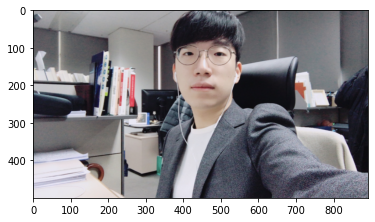

In [3]:
import cv2
from matplotlib import pyplot as plt

# 이미지 주소 지정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
# 이미지 불러오기
img_orig = cv2.imread(img_path)

# 이미지 크기 확인하기
print(img_orig.shape)

# 이미지를 matplotlib로 띄우기
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 이미지 세그멘테이션

In [4]:
# 모델에 이미지 집어넣기
segvalues, output = model.segmentAsPascalvoc(img_path)

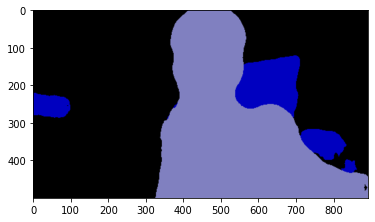

In [5]:
# 세그멘테이션 결과 사진 보기
plt.imshow(output)
plt.show()

In [6]:
# 각 클래스가 나타내는 의미
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
# 여기서 사람이 검출되는지 확인하기
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


In [7]:
import numpy as np

# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

(500, 892)


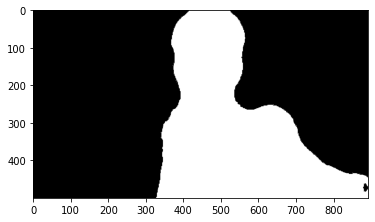

In [8]:
# colormap에서 사람에 해당하는 컬러값을 찾기
# 이미지가 BGR 방식으로 저장되어있기 때문에 colormap에서 찾은 색상도 BGR로 변경해야 한다
seg_color = tuple(reversed(colormap[LABEL_NAMES.index('person')]))

# 사람이 어느 부분에 있는지 나타내는 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# 블러 효과 주기

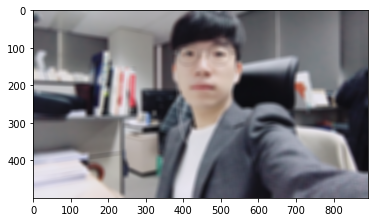

In [9]:
# cv2를 통해 블러 이미지 만들기
img_orig_blur = cv2.blur(img_orig, (13,13))

# 블러 효과가 잘 작동하는지 확인 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

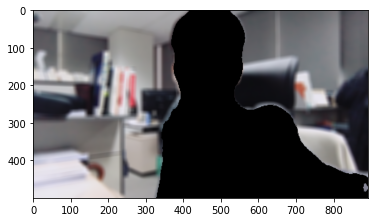

In [10]:
# 그레이스케일 형식의 마스크를 BGR 형식으로 전환하기
# 이미지들을 합쳐 효과를 줄 때는 색 표현 방식이 서로 같아야 한다
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 배경만 나타내는 마스크 만들기
img_bg_mask = cv2.bitwise_not(img_mask_color)

# blur된 이미지에서 사람을 빼고 배경만 남기기
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

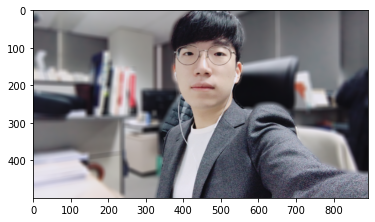

In [11]:
# 사람은 원본 이미지, 배경은 blur 이미지로 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# 결과 확인하기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 블러 효과를 함수로 만들기

In [12]:
def get_image_blur(img_path, label, show_mask=False):
    # 이미지 불러오기
    img_orig = cv2.imread(img_path)
    
    # 이미지 세그멘테이션
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    found_labels = [LABEL_NAMES[i] for i in segvalues['class_ids']]
    
    # 라벨에 해당하는 컬러값 찾기
    # 만약 해당하는 라벨이 존재하지 않거나 이미지에서 검출되지 않으면 (255,255,255)로 지정
    if label in LABEL_NAMES and label in found_labels:
        seg_color = tuple(reversed(colormap[LABEL_NAMES.index(label)]))
    else:
        seg_color = (255, 255, 255)

    # 원하는 라벨을 나타내는 마스크 만들기
    seg_map = np.all(output==seg_color, axis=-1) 
    
    # blur 효과가 들어간 사진 만들기
    img_orig_blur = cv2.blur(img_orig, (13,13))
    
    # 그레이스케일 형식의 마스크를 BGR 형식으로 전환하기
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # 배경만 나타내는 마스크 만들기
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # blur된 이미지에서 대상을 빼고 배경만 남기기
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    # 사람은 원본 이미지, 배경은 blur 이미지로 합치기
    if show_mask:
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_mask)
    else:
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

    return cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

# 블러 함수로 여러 이미지 블러 효과 주기

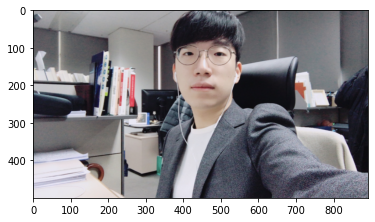

In [13]:
# 첫번째 인물사진: 혼자
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

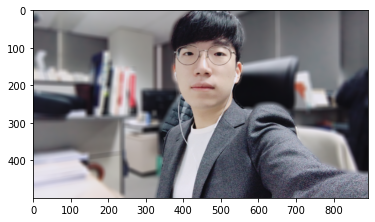

In [14]:
img_res = get_image_blur(img_path, 'person')
plt.imshow(img_res)
plt.show()

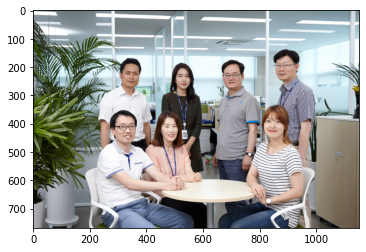

In [15]:
# 두번째 인물사진: 단체사진
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/group_img.jpg'  
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

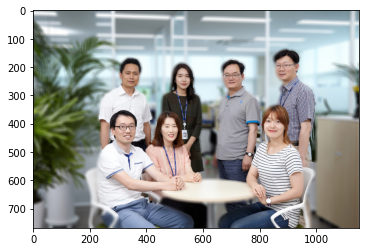

In [16]:
img_res = get_image_blur(img_path, 'person')
plt.imshow(img_res)
plt.show()

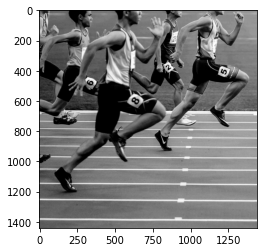

In [17]:
# 세번째 인물사진: 흑백, 옆모습, 일부분이 잘려있음
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/black_n_white.jpg'  
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

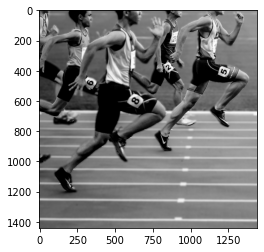

In [18]:
img_res = get_image_blur(img_path, 'person')
plt.imshow(img_res)
plt.show()

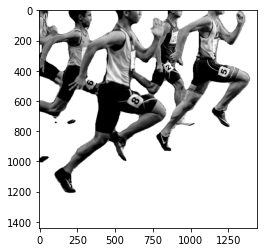

In [19]:
# 잘 안보여서 배경을 지워서 확인
img_res = get_image_blur(img_path, 'person', show_mask=True)
plt.imshow(img_res)
plt.show()

# 동물 사진에도 적용하기

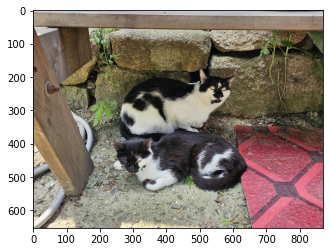

In [21]:
# 첫번째 동물사진
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

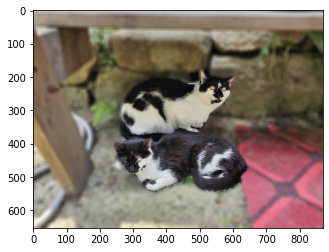

In [22]:
img_res = get_image_blur(img_path, 'cat')
plt.imshow(img_res)
plt.show()

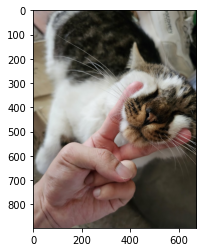

In [23]:
# 두번째 동물사진
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.png'
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

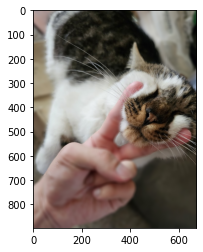

In [24]:
img_res = get_image_blur(img_path, 'cat')
plt.imshow(img_res)
plt.show()

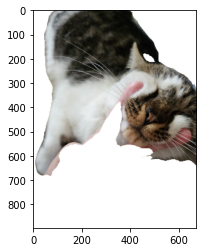

In [25]:
img_res = get_image_blur(img_path, 'cat', show_mask=True)
plt.imshow(img_res)
plt.show()

# 세그멘테이션을 이용한 배경 바꾸기

In [49]:
def change_background(img_path, bg_path, label, show_mask=False):
    # 이미지 불러오기
    img_orig = cv2.imread(img_path)
    img_bg = cv2.imread(bg_path)
    img_bg = cv2.resize(img_bg, dsize=(img_orig.shape[1],img_orig.shape[0]))
    
    # 이미지 세그멘테이션
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    found_labels = [LABEL_NAMES[i] for i in segvalues['class_ids']]
    
    # 라벨에 해당하는 컬러값 찾기
    # 만약 해당하는 라벨이 존재하지 않거나 이미지에서 검출되지 않으면 (255,255,255)로 지정
    if label in LABEL_NAMES and label in found_labels:
        seg_color = tuple(reversed(colormap[LABEL_NAMES.index(label)]))
    else:
        seg_color = (255, 255, 255)

    # 원하는 라벨을 나타내는 마스크 만들기
    seg_map = np.all(output==seg_color, axis=-1)
    
    # 그레이스케일 형식의 마스크를 BGR 형식으로 전환하기
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # 배경만 나타내는 마스크 만들기
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # blur된 이미지에서 대상을 빼고 배경만 남기기
    img_bg = cv2.bitwise_and(img_bg, img_bg_mask)
    
    # 사람은 원본 이미지, 배경은 blur 이미지로 합치기
    if show_mask:
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_mask)
    else:
        img_concat = np.where(img_mask_color==255, img_orig, img_bg)

    return cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

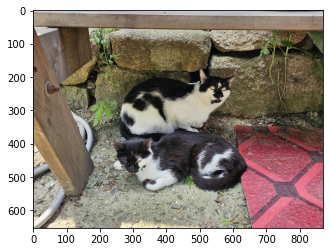

In [50]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

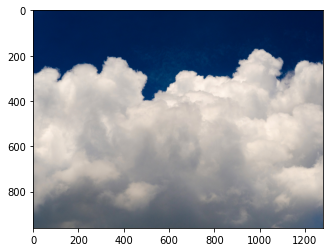

In [51]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cloud.jpeg'
img_bg = cv2.imread(bg_path)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

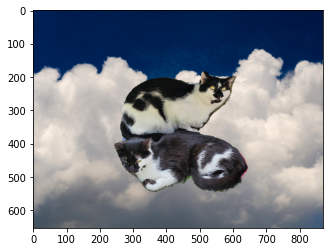

In [52]:
img_res = change_background(img_path, bg_path, 'cat')
plt.imshow(img_res)
plt.show()